# Brain Tumor Detection - Model Testing & Visualization

Test all trained models and visualize predictions with detailed metrics.

**Models to test:**
1. U-Net (Baseline)
2. ResNet-UNet (Baseline)
3. Lightweight Transformer (Proposed)

## 1. Setup and Imports

In [10]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
import time

sys.path.append('src')

import config
from models import get_model
from datasets.brain_tumor_dataset import get_dataloaders
from losses.combined_loss import MultiTaskLoss
from utils.metrics import (
    calculate_classification_metrics, 
    calculate_iou,
    calculate_dice_coefficient,
    count_parameters
)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports successful")
print(f"Device: {config.DEVICE}")

✓ Imports successful
Device: cuda


## 2. Configuration

In [24]:
# Models and their checkpoints
MODELS_TO_TEST = {
    'unet': 'checkpoints/unet_best.pth',
    'resnet_unet': 'checkpoints/resnet_unet_best.pth',
    'lightweight_transformer': 'checkpoints/lightweight_transformer_best.pth'
}

# Visualization settings
NUM_SAMPLES_TO_DISPLAY = 5
SAVE_ALL_TEST_IMAGES = True

print(f"Models to test: {list(MODELS_TO_TEST.keys())}")
print(f"Samples to display in notebook: {NUM_SAMPLES_TO_DISPLAY}")
print(f"Save all test images: {SAVE_ALL_TEST_IMAGES}")

Models to test: ['unet', 'resnet_unet', 'lightweight_transformer']
Samples to display in notebook: 5
Save all test images: True


## 3. Load Test Data

In [25]:
print("Loading test dataset...")
_, _, test_loader = get_dataloaders(
    train_dir=config.TRAIN_DIR,
    val_dir=config.VAL_DIR,
    test_dir=config.TEST_DIR,
    train_ann=config.TRAIN_ANNOTATIONS,
    val_ann=config.VAL_ANNOTATIONS,
    test_ann=config.TEST_ANNOTATIONS,
    batch_size=8,
    num_workers=4,
    image_size=config.IMAGE_SIZE
)

print(f"✓ Test data loaded: {len(test_loader)} batches")

Loading test dataset...
✓ Test data loaded: 27 batches


## 4. Test All Models

In [26]:
def test_model(model_name, checkpoint_path):
    """
    Test a single model and return comprehensive metrics
    """
    print(f"\n{'='*60}")
    print(f"Testing: {model_name.upper()}")
    print(f"{'='*60}")
    
    # Load model
    model = get_model(
        model_name=model_name,
        n_classes_seg=config.SEGMENTATION_CLASSES,
        n_classes_cls=config.NUM_CLASSES - 1,
        img_size=config.IMAGE_SIZE
    ).to(config.DEVICE)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    num_params = count_parameters(model)
    print(f"Parameters: {num_params:,} ({num_params/1e6:.2f}M)")
    
    # Initialize criterion
    criterion = MultiTaskLoss(
        classification_weight=config.CLASSIFICATION_WEIGHT,
        segmentation_weight=config.SEGMENTATION_WEIGHT
    )
    
    # Test loop
    test_loss = 0.0
    all_cls_preds, all_cls_targets = [], []
    all_seg_preds, all_seg_targets = [], []
    inference_times = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Testing'):
            images = batch['image'].to(config.DEVICE)
            seg_masks = batch['segmentation_mask'].to(config.DEVICE)
            cls_labels = batch['classification_label'].to(config.DEVICE)
            
            # Measure inference time
            start_time = time.time()
            cls_output, seg_output = model(images)
            inference_time = time.time() - start_time
            inference_times.append(inference_time / images.size(0))
            
            # Calculate loss
            loss_dict = criterion(cls_output, seg_output, cls_labels, seg_masks)
            test_loss += loss_dict['total_loss'].item()
            
            # Store predictions
            all_cls_preds.append(torch.argmax(cls_output, dim=1).cpu())
            all_cls_targets.append(cls_labels.cpu())
            all_seg_preds.append(torch.argmax(seg_output, dim=1).cpu())
            all_seg_targets.append(seg_masks.cpu())
    
    # Concatenate predictions
    all_cls_preds = torch.cat(all_cls_preds)
    all_cls_targets = torch.cat(all_cls_targets)
    all_seg_preds = torch.cat(all_seg_preds)
    all_seg_targets = torch.cat(all_seg_targets)
    
    # Calculate metrics
    test_loss /= len(test_loader)
    cls_metrics = calculate_classification_metrics(all_cls_preds, all_cls_targets)
    seg_iou = calculate_iou(all_seg_preds, all_seg_targets, num_classes=2)
    seg_dice = calculate_dice_coefficient(all_seg_preds, all_seg_targets, num_classes=2)
    
    avg_inference_time = np.mean(inference_times)
    fps = 1.0 / avg_inference_time
    
    # Confusion matrix
    cm = confusion_matrix(all_cls_targets.numpy(), all_cls_preds.numpy())
    
    # Results dictionary
    results = {
        'model_name': model_name,
        'parameters': num_params,
        'test_loss': test_loss,
        'accuracy': cls_metrics['accuracy'],
        'precision': cls_metrics['precision'],
        'recall': cls_metrics['recall'],
        'f1_score': cls_metrics['f1_score'],
        'mean_iou': seg_iou,
        'dice_coefficient': seg_dice,
        'inference_time': avg_inference_time,
        'fps': fps,
        'confusion_matrix': cm,
        'predictions': {
            'cls_preds': all_cls_preds,
            'cls_targets': all_cls_targets,
            'seg_preds': all_seg_preds,
            'seg_targets': all_seg_targets
        }
    }
    
    # Print summary
    print(f"\nTest Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Classification Accuracy: {cls_metrics['accuracy']:.4f}")
    print(f"  Precision: {cls_metrics['precision']:.4f}")
    print(f"  Recall: {cls_metrics['recall']:.4f}")
    print(f"  F1-Score: {cls_metrics['f1_score']:.4f}")
    print(f"  Segmentation mIoU: {seg_iou:.4f}")
    print(f"  Dice Coefficient: {seg_dice:.4f}")
    print(f"  Inference Time: {avg_inference_time*1000:.2f} ms/image")
    print(f"  FPS: {fps:.2f}")
    
    return results

# Test all models
all_results = {}

for model_name, checkpoint_path in MODELS_TO_TEST.items():
    if os.path.exists(checkpoint_path):
        results = test_model(model_name, checkpoint_path)
        all_results[model_name] = results
    else:
        print(f"\n⚠ Checkpoint not found: {checkpoint_path}")

print(f"\n✓ Testing completed for {len(all_results)} models")


Testing: UNET
Parameters: 31,569,412 (31.57M)


Testing: 100%|██████████| 27/27 [00:04<00:00,  5.44it/s]



Test Results:
  Test Loss: 0.0864
  Classification Accuracy: 0.9860
  Precision: 0.9861
  Recall: 0.9860
  F1-Score: 0.9860
  Segmentation mIoU: 0.7160
  Dice Coefficient: 0.8078
  Inference Time: 0.34 ms/image
  FPS: 2908.70

Testing: RESNET_UNET


/home/siu856569517/.conda/envs/brain_tumor/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/siu856569517/.conda/envs/brain_tumor/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameters: 60,565,156 (60.57M)


Testing: 100%|██████████| 27/27 [00:03<00:00,  7.16it/s]



Test Results:
  Test Loss: 0.0550
  Classification Accuracy: 0.9953
  Precision: 0.9954
  Recall: 0.9953
  F1-Score: 0.9954
  Segmentation mIoU: 0.8017
  Dice Coefficient: 0.8788
  Inference Time: 0.60 ms/image
  FPS: 1661.28

Testing: LIGHTWEIGHT_TRANSFORMER
Parameters: 4,083,876 (4.08M)


Testing: 100%|██████████| 27/27 [00:02<00:00, 11.43it/s]



Test Results:
  Test Loss: 0.1205
  Classification Accuracy: 0.9628
  Precision: 0.9628
  Recall: 0.9628
  F1-Score: 0.9628
  Segmentation mIoU: 0.7205
  Dice Coefficient: 0.8122
  Inference Time: 0.78 ms/image
  FPS: 1283.02

✓ Testing completed for 3 models


## 5. Compare Models - Summary Table

In [27]:
# Create comparison table
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Parameters (M)': f"{results['parameters']/1e6:.2f}",
        'Test Loss': f"{results['test_loss']:.4f}",
        'Accuracy': f"{results['accuracy']:.4f}",
        'Precision': f"{results['precision']:.4f}",
        'Recall': f"{results['recall']:.4f}",
        'F1-Score': f"{results['f1_score']:.4f}",
        'mIoU': f"{results['mean_iou']:.4f}",
        'Dice': f"{results['dice_coefficient']:.4f}",
        'FPS': f"{results['fps']:.2f}"
    })

df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("MODEL COMPARISON - TEST SET RESULTS")
print("="*100)
print(df.to_string(index=False))
print("="*100)

# Save to CSV
df.to_csv('results/test_comparison.csv', index=False)
print("\n✓ Comparison saved to results/test_comparison.csv")


MODEL COMPARISON - TEST SET RESULTS
                  Model Parameters (M) Test Loss Accuracy Precision Recall F1-Score   mIoU   Dice     FPS
                   unet          31.57    0.0864   0.9860    0.9861 0.9860   0.9860 0.7160 0.8078 2908.70
            resnet_unet          60.57    0.0550   0.9953    0.9954 0.9953   0.9954 0.8017 0.8788 1661.28
lightweight_transformer           4.08    0.1205   0.9628    0.9628 0.9628   0.9628 0.7205 0.8122 1283.02

✓ Comparison saved to results/test_comparison.csv


## 6. Visualize Comparison Metrics

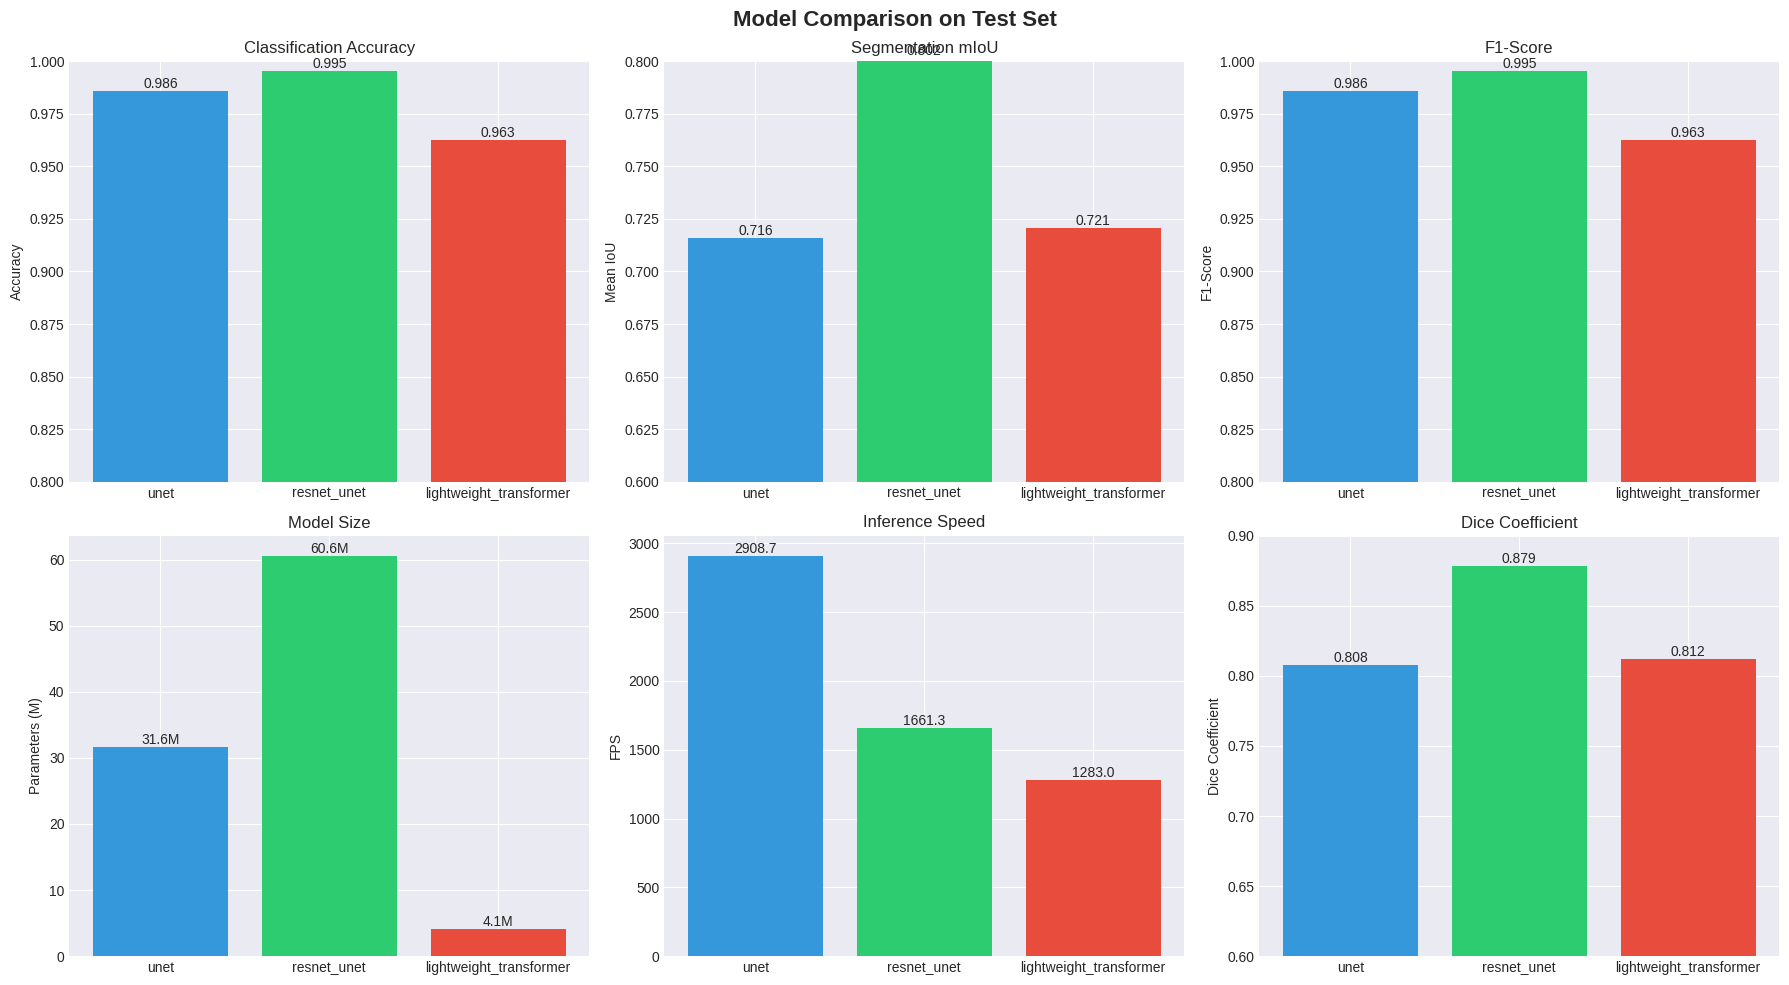

✓ Comparison plots saved to results/test_metrics_comparison.png


In [28]:
# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Comparison on Test Set', fontsize=16, fontweight='bold')

models = list(all_results.keys())
colors = ['#3498db', '#2ecc71', '#e74c3c']

# 1. Accuracy
accuracies = [all_results[m]['accuracy'] for m in models]
bars = axes[0, 0].bar(models, accuracies, color=colors)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Classification Accuracy')
axes[0, 0].set_ylim([0.8, 1.0])
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{accuracies[i]:.3f}', ha='center', va='bottom')

# 2. mIoU
mious = [all_results[m]['mean_iou'] for m in models]
bars = axes[0, 1].bar(models, mious, color=colors)
axes[0, 1].set_ylabel('Mean IoU')
axes[0, 1].set_title('Segmentation mIoU')
axes[0, 1].set_ylim([0.6, 0.8])
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{mious[i]:.3f}', ha='center', va='bottom')

# 3. F1-Score
f1_scores = [all_results[m]['f1_score'] for m in models]
bars = axes[0, 2].bar(models, f1_scores, color=colors)
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].set_title('F1-Score')
axes[0, 2].set_ylim([0.8, 1.0])
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height,
                   f'{f1_scores[i]:.3f}', ha='center', va='bottom')

# 4. Parameters
params = [all_results[m]['parameters']/1e6 for m in models]
bars = axes[1, 0].bar(models, params, color=colors)
axes[1, 0].set_ylabel('Parameters (M)')
axes[1, 0].set_title('Model Size')
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{params[i]:.1f}M', ha='center', va='bottom')

# 5. FPS
fps_values = [all_results[m]['fps'] for m in models]
bars = axes[1, 1].bar(models, fps_values, color=colors)
axes[1, 1].set_ylabel('FPS')
axes[1, 1].set_title('Inference Speed')
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{fps_values[i]:.1f}', ha='center', va='bottom')

# 6. Dice Coefficient
dice_scores = [all_results[m]['dice_coefficient'] for m in models]
bars = axes[1, 2].bar(models, dice_scores, color=colors)
axes[1, 2].set_ylabel('Dice Coefficient')
axes[1, 2].set_title('Dice Coefficient')
axes[1, 2].set_ylim([0.6, 0.9])
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                   f'{dice_scores[i]:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('results/test_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison plots saved to results/test_metrics_comparison.png")

## 7. Confusion Matrices

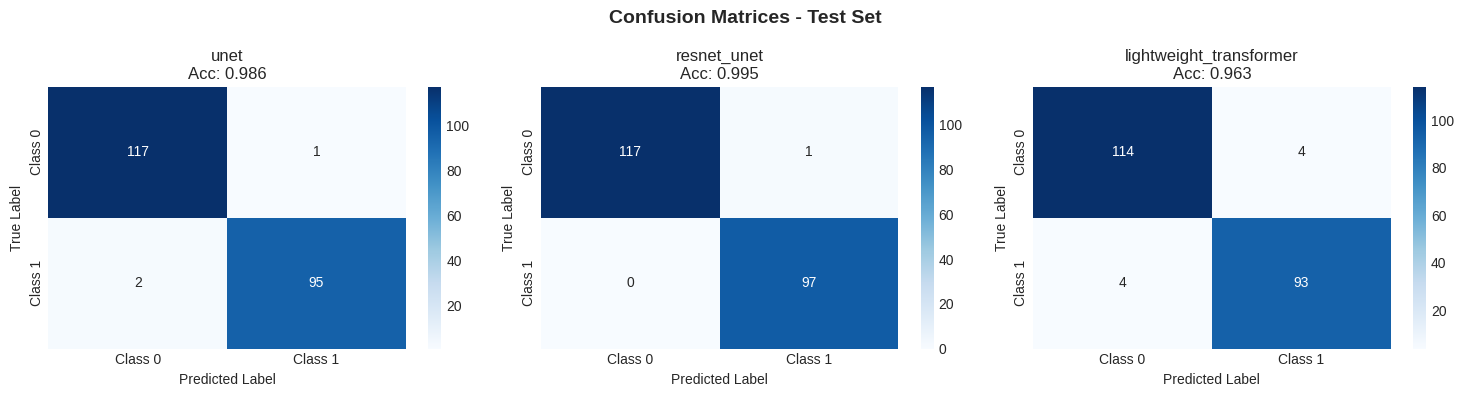

✓ Confusion matrices saved to results/confusion_matrices.png


In [29]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Confusion Matrices - Test Set', fontsize=14, fontweight='bold')

for idx, (model_name, results) in enumerate(all_results.items()):
    cm = results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               xticklabels=['Class 0', 'Class 1'],
               yticklabels=['Class 0', 'Class 1'])
    axes[idx].set_title(f'{model_name}\nAcc: {results["accuracy"]:.3f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('results/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved to results/confusion_matrices.png")

## 8. Visualize Sample Predictions


Processing ALL test images for unet (displaying first 5)...


/tmp/ipykernel_707965/1687631907.py:73: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_707965/1687631907.py:74: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.savefig(f'{output_dir}/sample_{sample_count+1}.png', dpi=150, bbox_inches='tight')
/home/siu856569517/.conda/envs/brain_tumor/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


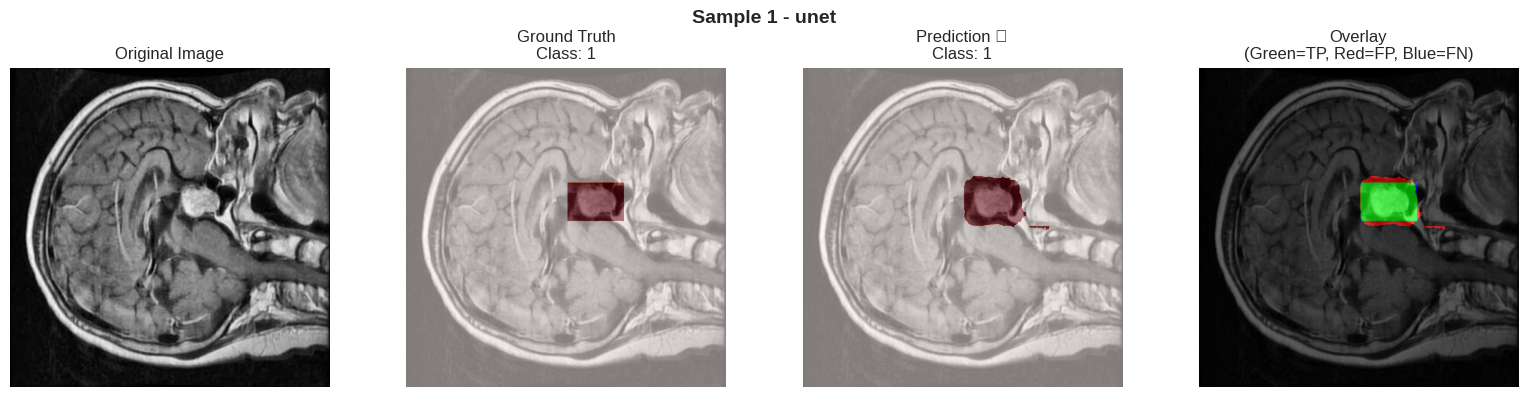

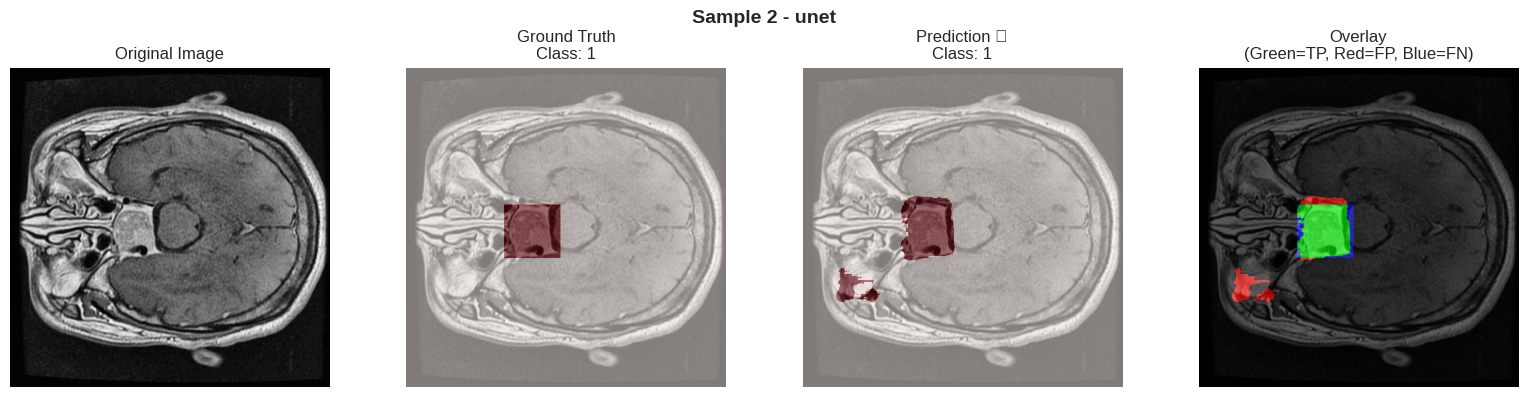

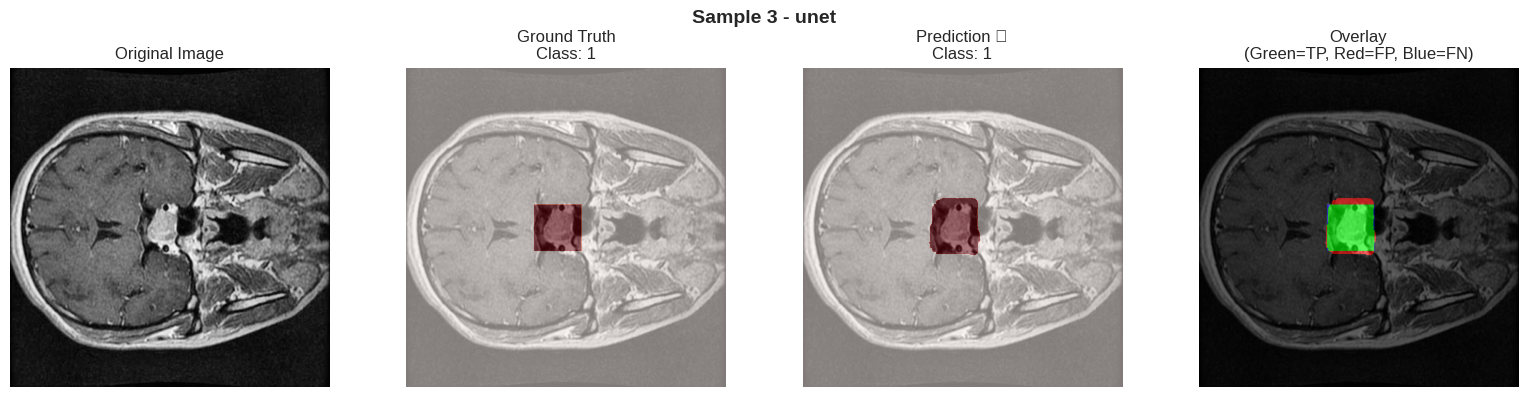

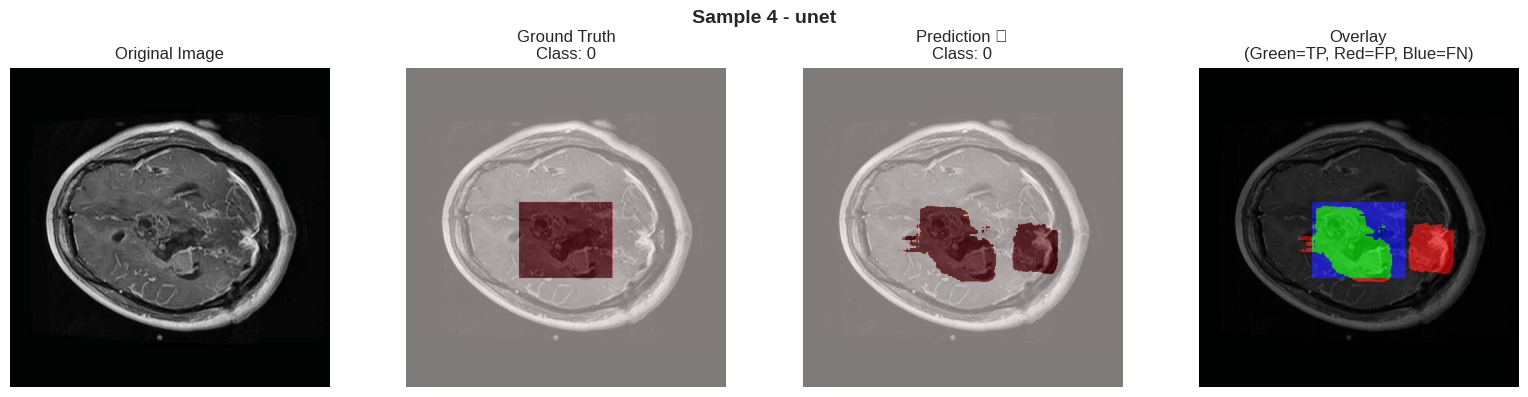

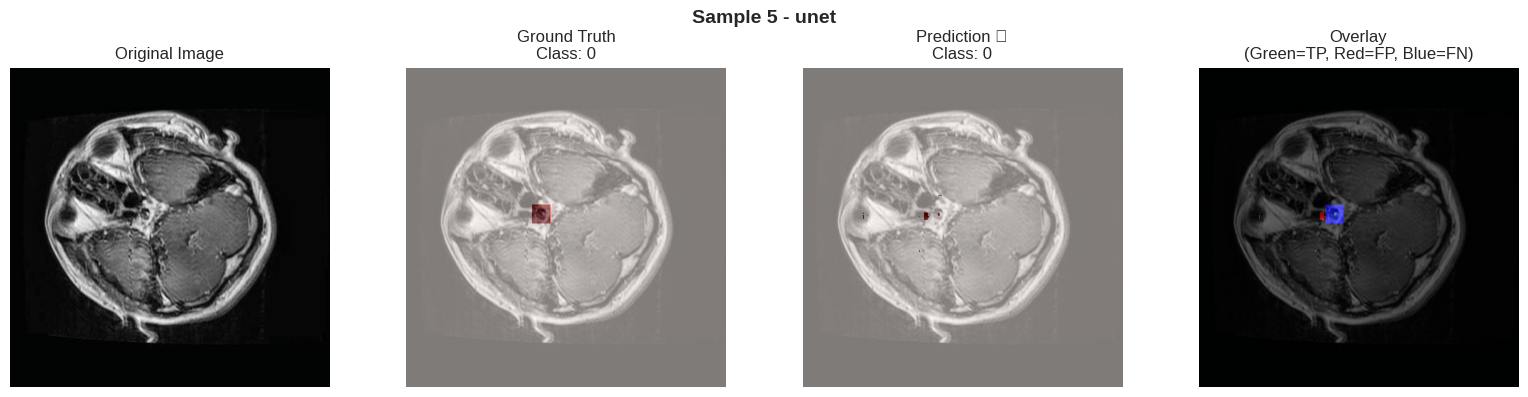

/tmp/ipykernel_707965/1687631907.py:73: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_707965/1687631907.py:74: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  plt.savefig(f'{output_dir}/sample_{sample_count+1}.png', dpi=150, bbox_inches='tight')


✓ 215 predictions saved to results/unet_predictions/

Processing ALL test images for resnet_unet (displaying first 5)...


/home/siu856569517/.conda/envs/brain_tumor/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/siu856569517/.conda/envs/brain_tumor/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


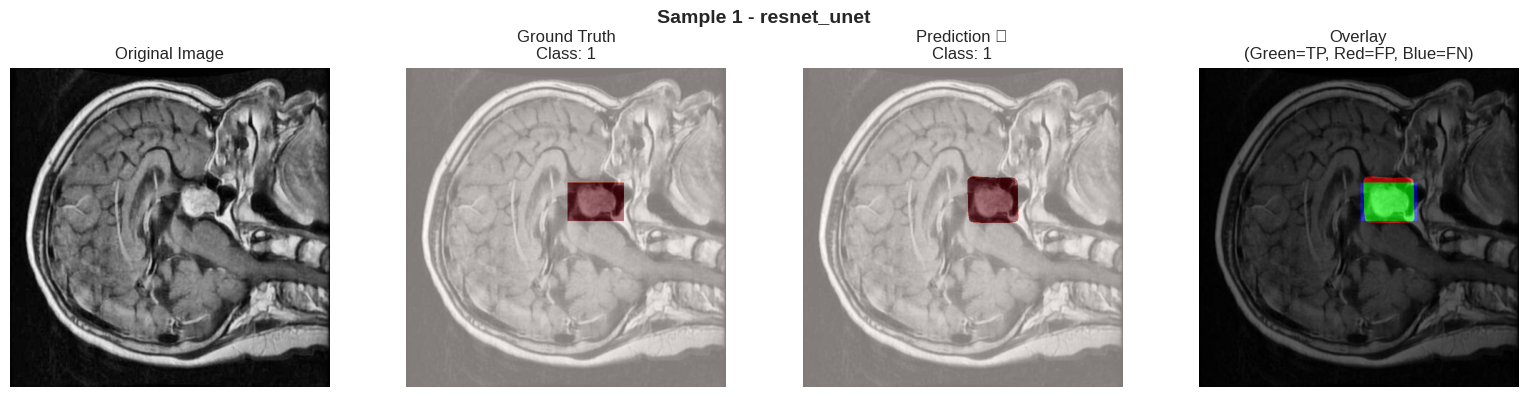

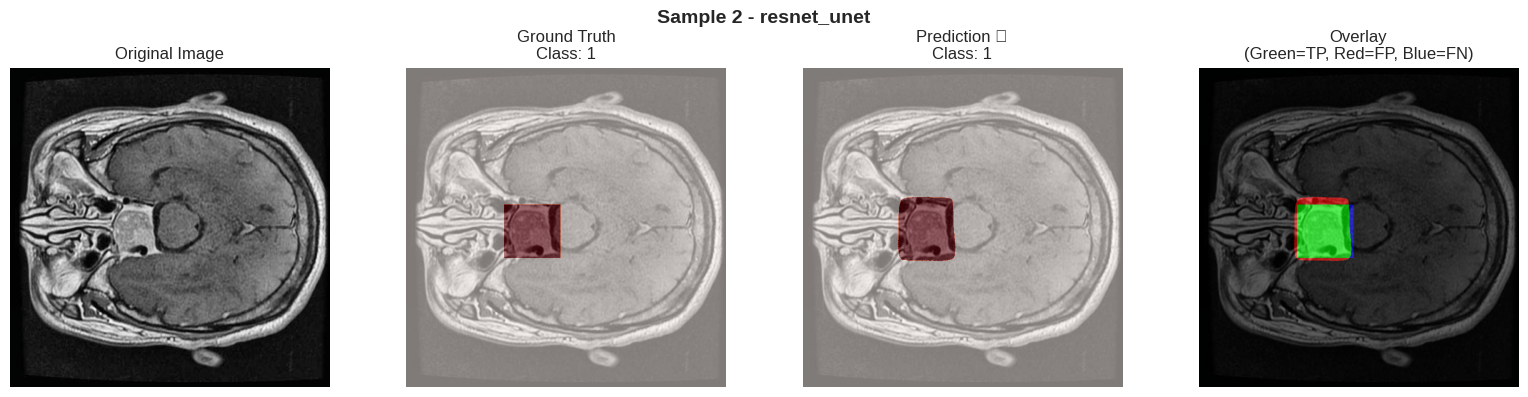

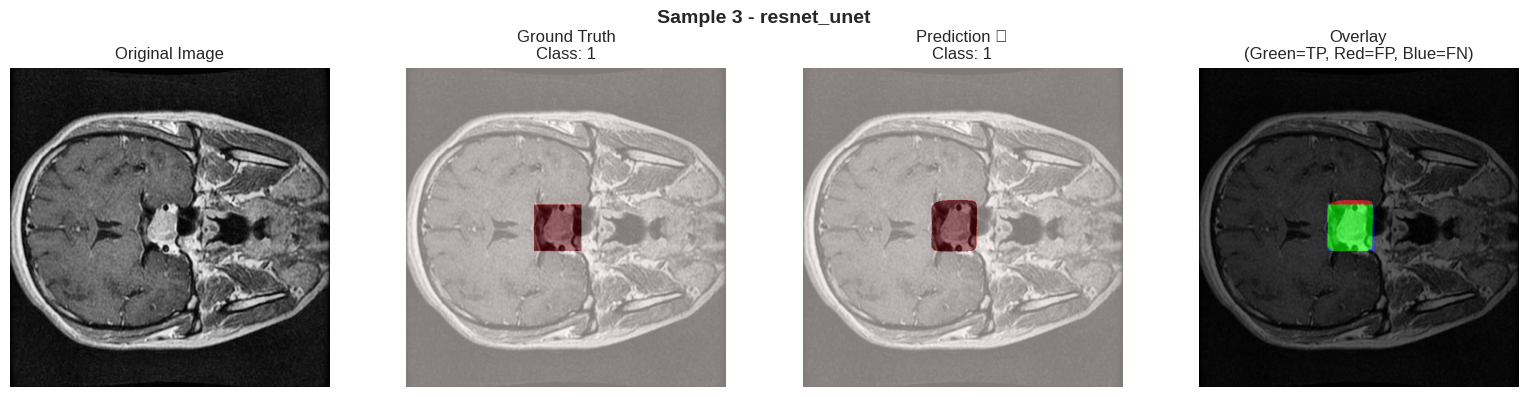

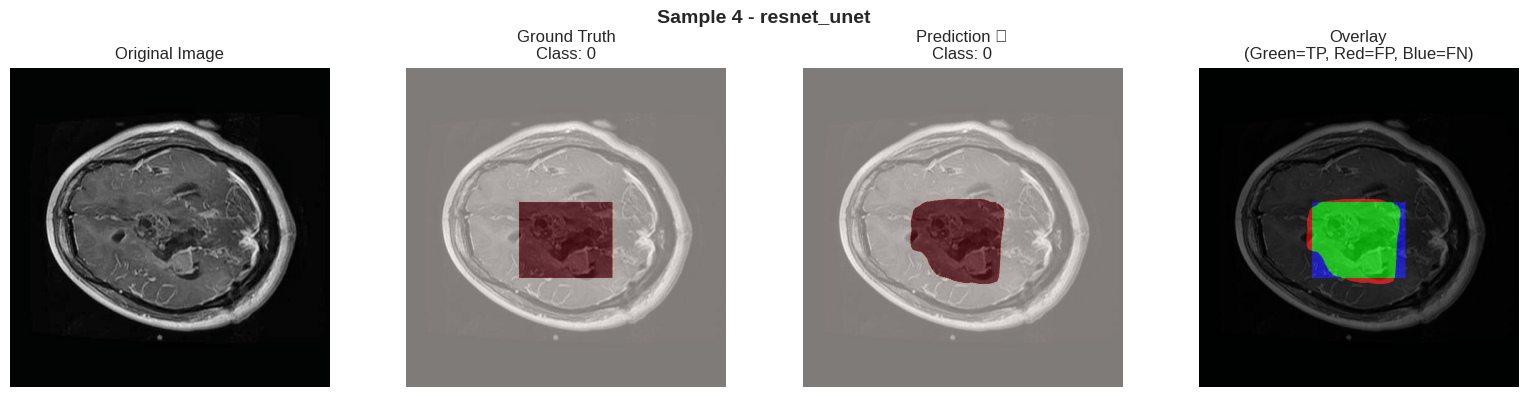

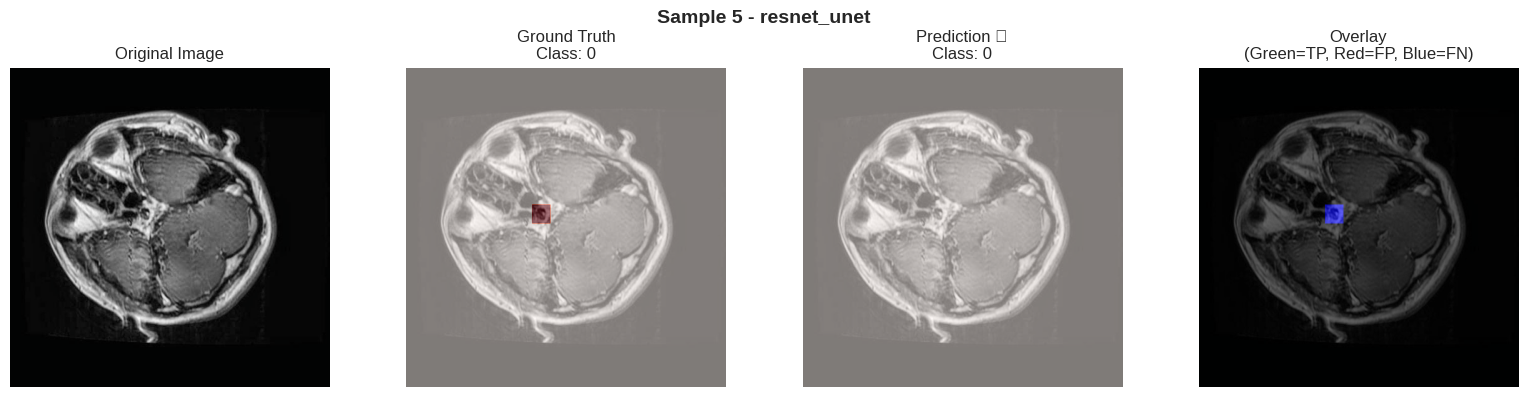

✓ 215 predictions saved to results/resnet_unet_predictions/

Processing ALL test images for lightweight_transformer (displaying first 5)...


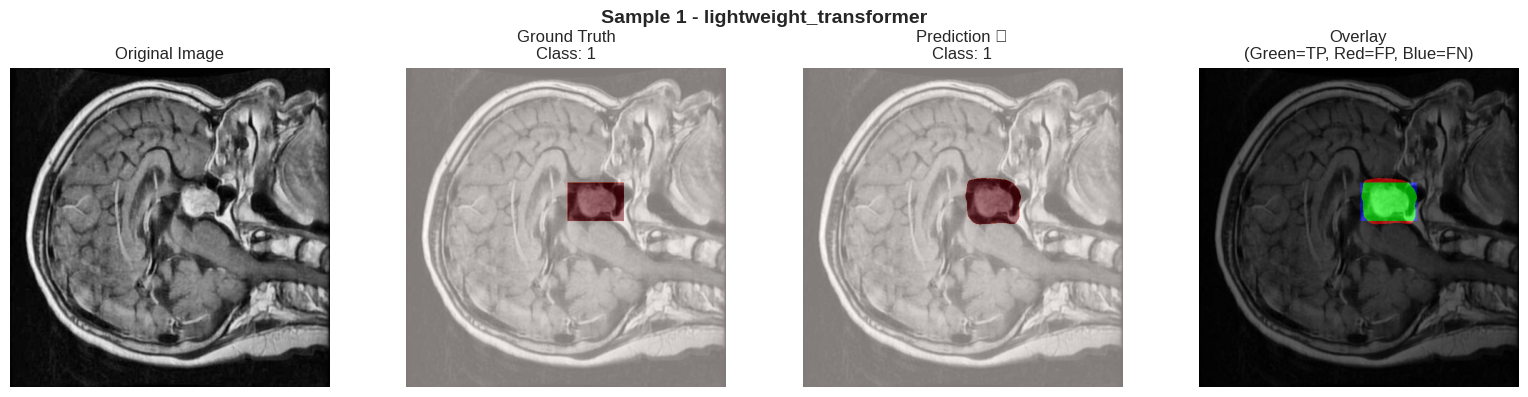

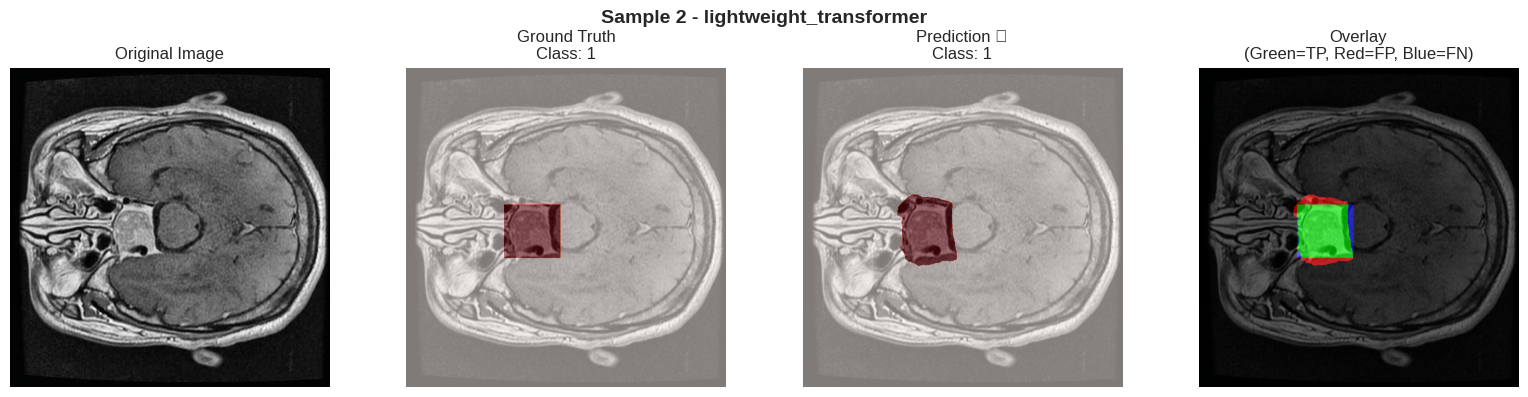

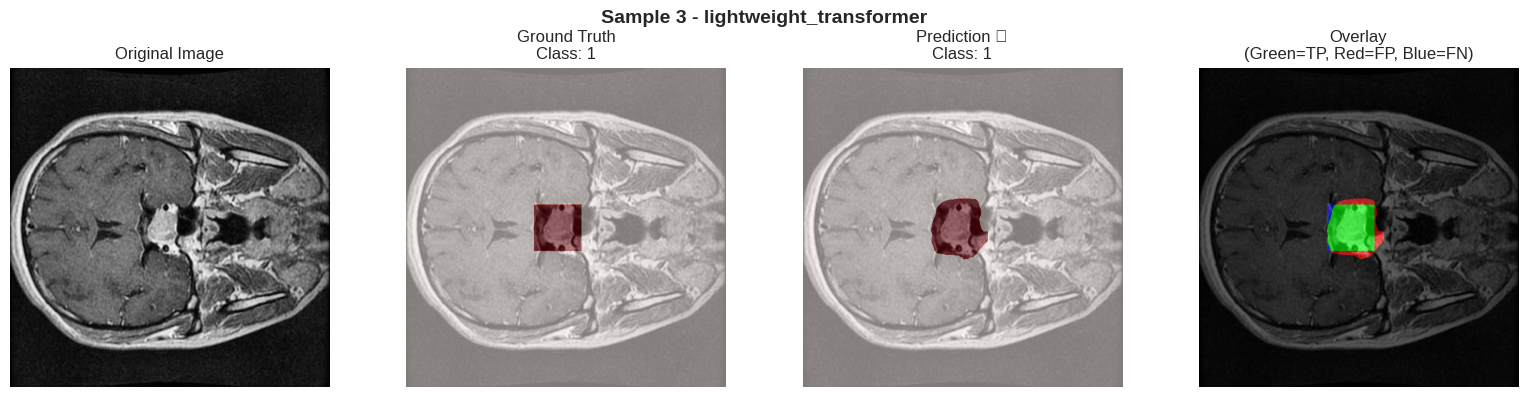

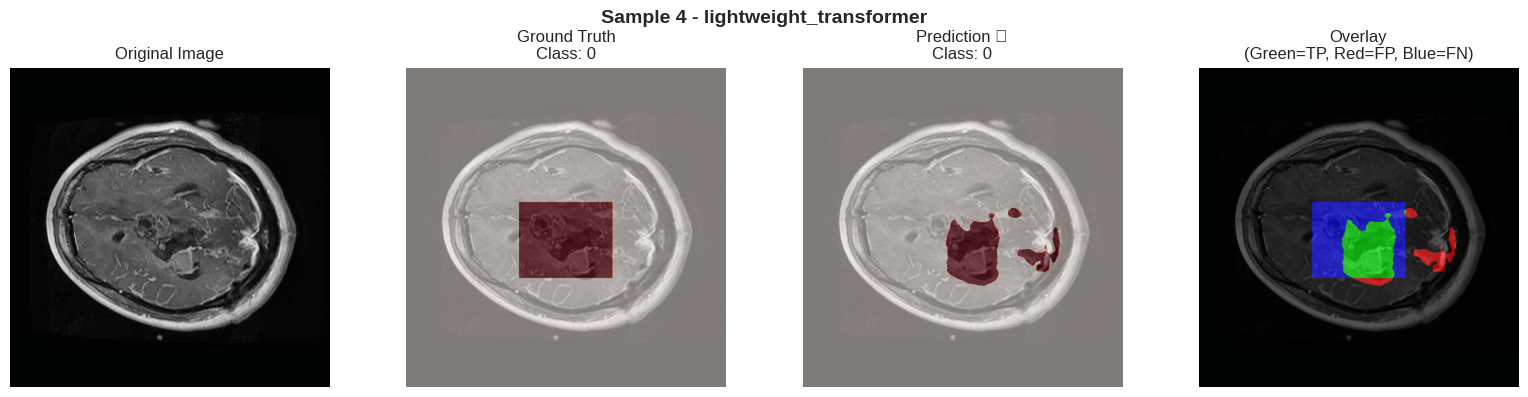

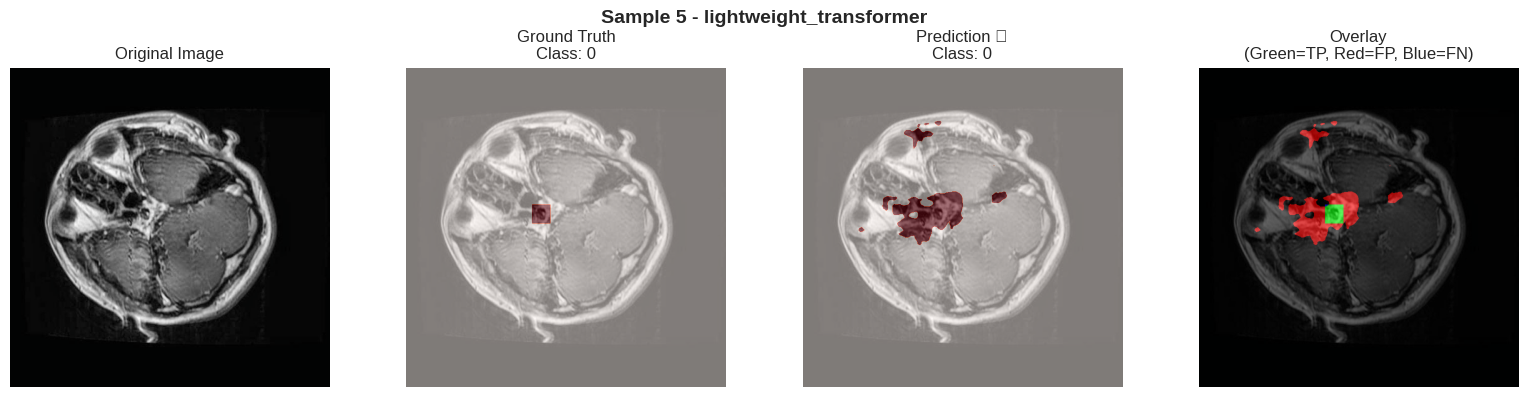

✓ 215 predictions saved to results/lightweight_transformer_predictions/

✓ All visualizations completed for 3 models


In [30]:
def denormalize_image(image_tensor):
    """Denormalize image for visualization"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image_tensor.cpu().numpy().transpose(1, 2, 0)
    image = std * image + mean
    return np.clip(image, 0, 1)

def visualize_model_predictions(model_name, checkpoint_path, num_to_display=5, save_all=True):
    """Visualize and save predictions for a specific model"""
    if save_all:
        print(f"\nProcessing ALL test images for {model_name} (displaying first {num_to_display})...")
    else:
        print(f"\nProcessing {num_to_display} samples for {model_name}...")
    
    output_dir = f'results/{model_name}_predictions'
    os.makedirs(output_dir, exist_ok=True)
    
    model = get_model(
        model_name=model_name,
        n_classes_seg=config.SEGMENTATION_CLASSES,
        n_classes_cls=config.NUM_CLASSES - 1,
        img_size=config.IMAGE_SIZE
    ).to(config.DEVICE)
    
    checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    sample_count = 0
    for batch in test_loader:
        images = batch['image'].to(config.DEVICE)
        seg_masks = batch['segmentation_mask']
        cls_labels = batch['classification_label']
        
        with torch.no_grad():
            cls_output, seg_output = model(images)
            cls_preds = torch.argmax(cls_output, dim=1).cpu()
            seg_preds = torch.argmax(seg_output, dim=1).cpu()
        
        for i in range(images.size(0)):
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            
            img = denormalize_image(images[i])
            
            axes[0].imshow(img)
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            
            axes[1].imshow(img)
            axes[1].imshow(seg_masks[i].numpy(), alpha=0.5, cmap='Reds')
            axes[1].set_title(f'Ground Truth\nClass: {cls_labels[i].item()}')
            axes[1].axis('off')
            
            axes[2].imshow(img)
            axes[2].imshow(seg_preds[i].numpy(), alpha=0.5, cmap='Reds')
            correct = '✓' if cls_preds[i].item() == cls_labels[i].item() else '✗'
            axes[2].set_title(f'Prediction {correct}\nClass: {cls_preds[i].item()}')
            axes[2].axis('off')
            
            gt = seg_masks[i].numpy()
            pred = seg_preds[i].numpy()
            overlay = np.zeros((*gt.shape, 3))
            overlay[np.logical_and(gt == 1, pred == 1)] = [0, 1, 0]
            overlay[np.logical_and(gt == 0, pred == 1)] = [1, 0, 0]
            overlay[np.logical_and(gt == 1, pred == 0)] = [0, 0, 1]
            axes[3].imshow(img)
            axes[3].imshow(overlay, alpha=0.6)
            axes[3].set_title('Overlay\n(Green=TP, Red=FP, Blue=FN)')
            axes[3].axis('off')
            
            plt.suptitle(f'Sample {sample_count + 1} - {model_name}', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig(f'{output_dir}/sample_{sample_count+1}.png', dpi=150, bbox_inches='tight')
            
            if sample_count < num_to_display:
                plt.show()
            else:
                plt.close(fig)
            
            sample_count += 1
        
        if not save_all and sample_count >= num_to_display:
            break
    
    print(f"✓ {sample_count} predictions saved to {output_dir}/")
    return sample_count

for model_name, checkpoint_path in MODELS_TO_TEST.items():
    if os.path.exists(checkpoint_path):
        visualize_model_predictions(model_name, checkpoint_path, NUM_SAMPLES_TO_DISPLAY, SAVE_ALL_TEST_IMAGES)
    else:
        print(f"\n⚠ Checkpoint not found: {checkpoint_path}")

print(f"\n✓ All visualizations completed for {len(all_results)} models")

## 9. Summary and Best Model

In [ ]:
# Find best model by accuracy
best_model = max(all_results.items(), key=lambda x: x[1]['accuracy'])
best_name = best_model[0]
best_res = best_model[1]

# Find most efficient model (best FPS/param ratio)
efficiency_scores = {name: res['fps'] / (res['parameters']/1e6) 
                    for name, res in all_results.items()}
most_efficient = max(efficiency_scores.items(), key=lambda x: x[1])

print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nBEST MODEL (by Accuracy): {best_name.upper()}")
print(f"   Accuracy: {best_res['accuracy']:.4f}")
print(f"   mIoU: {best_res['mean_iou']:.4f}")
print(f"   F1-Score: {best_res['f1_score']:.4f}")
print(f"   Dice: {best_res['dice_coefficient']:.4f}")
print(f"   Parameters: {best_res['parameters']/1e6:.2f}M")
print(f"   FPS: {best_res['fps']:.2f}")

print(f"\nMOST EFFICIENT MODEL: {most_efficient[0].upper()}")
print(f"   Efficiency Score: {most_efficient[1]:.2f} (FPS/M params)")
print(f"   FPS: {all_results[most_efficient[0]]['fps']:.2f}")
print(f"   Parameters: {all_results[most_efficient[0]]['parameters']/1e6:.2f}M")

total_test_images = len(test_loader.dataset)

print("\n" + "="*80)
print("\nAll testing and visualization completed!")
print("\nGenerated files:")
print("  - results/test_comparison.csv")
print("  - results/test_metrics_comparison.png")
print("  - results/confusion_matrices.png")
for model_name in all_results.keys():
    print(f"  - results/{model_name}_predictions/ ({total_test_images} images)")
print("\n" + "="*80)


FINAL SUMMARY

BEST MODEL (by Accuracy): RESNET_UNET
   Accuracy: 0.9953
   mIoU: 0.8017
   F1-Score: 0.9954
   Dice: 0.8788
   Parameters: 60.57M
   FPS: 1661.28

MOST EFFICIENT MODEL: LIGHTWEIGHT_TRANSFORMER
   Efficiency Score: 314.17 (FPS/M params)
   FPS: 1283.02
   Parameters: 4.08M


All testing and visualization completed!

Generated files:
  - results/test_comparison.csv
  - results/test_metrics_comparison.png
  - results/confusion_matrices.png
  - results/unet_predictions/ (215 images)
  - results/resnet_unet_predictions/ (215 images)
  - results/lightweight_transformer_predictions/ (215 images)



: 